In [5]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [6]:
def load_dataset(label_path):
    label = pd.read_csv(label_path)
    label = label.drop(columns=['Unnamed: 0'])
    dataset = label

    # load embeddings
    with open('./dataset_work/embeddings.json') as f:
        embeddings = json.load(f)
    all_embeddings = pd.DataFrame.from_dict(embeddings, orient='index', columns=['embedding'])
    all_embeddings.index.name = 'id'
    dataset = pd.merge(dataset, all_embeddings, on='id', how='left')

    # load personalities
    with open('./dataset_work/personalities.json') as f:
        personalities = json.load(f)
    all_personalities = pd.DataFrame.from_dict(personalities, orient='index', columns=['playfulness', 'chase-proneness', 'curiosity', 'sociability', 'aggressiveness', 'shyness'])
    all_personalities.index.name = 'id'
    dataset = pd.merge(dataset, all_personalities, on='id', how='left')

    return dataset

In [119]:
def vectorize_dataset(df, with_personalities, with_embeddings):
    if with_personalities and with_embeddings:
        cols = df[['embedding','playfulness', 'chase-proneness', 'curiosity', 'sociability', 'aggressiveness', 'shyness']]
        x = cols.values
        embeddings = x[:,0]
        expanded = np.array(embeddings.tolist())
        x = np.concatenate((expanded, x[:,1:]), axis=1)
        x = np.array(x, dtype='float64')
        y = df['label'].values
    elif with_embeddings:
        cols = df[['embedding','playfulness', 'chase-proneness', 'curiosity', 'sociability', 'aggressiveness', 'shyness']]
        x = cols.values
        embeddings = x[:,0]
        expanded = np.array(embeddings.tolist())
        x = expanded
        y = df['label'].values
    else:
        cols = df[['embedding','playfulness', 'chase-proneness', 'curiosity', 'sociability', 'aggressiveness', 'shyness']]
        x = cols.values
        x = x[:,1:]
        x = np.array(x, dtype="float64")
        y = df['label'].values
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


        

In [78]:
class Net(nn.Module):

    def __init__(self, INPUT_SIZE):
        super(Net, self).__init__()
        # Input is output of resnet18 image classification model
        self.fc1 = nn.Linear(INPUT_SIZE, 500) 
        self.fc11 = nn.Linear(500, 100)
        self.fc2 = nn.Linear(100, 1)
        self.act_out = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc11(x))
        x = self.act_out(self.fc2(x))
        return x

In [81]:
def train_loop(x_train, y_train, x_valid, y_valid, model, loss_fn, optimizer, batch_size, epoch_max):
    n_examples = x_train.shape[0]
    train_loss = np.zeros(epoch_max)
    valid_loss = np.zeros(epoch_max)
    for epoch in range(epoch_max):
        print(f"\033[1m-----------Epoch {epoch}------------\033[0m")
        for i in range(0, (n_examples // batch_size) + 1):
            x_slice = x_train[i:min(i+batch_size, n_examples), :]
            y_slice = y_train[i:min(i+batch_size, n_examples)]
            y_pred = model(x_slice)
            loss = loss_fn(y_pred, y_slice)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # ------- Graphing --------
        y_pred_train = model(x_train)
        y_pred_valid = model(x_valid)

        train_acc = (y_pred_train.round() == y_train).float().mean()
        valid_acc = (y_pred_valid.round() == y_valid).float().mean()

        train_loss[epoch] = train_acc
        valid_loss[epoch] = valid_acc
        # train_loss[epoch] = loss_fn(y_pred_train, y_train)
        # valid_loss[epoch] = loss_fn(y_pred_valid, y_valid)
        print(f"loss = {loss}")
    return train_loss, valid_loss

In [102]:
# --------- Images Only ---------
train = load_dataset('dataset_work/labels/image_only/alice_train_personalityFalse_imageTrue_labels.csv')
test = load_dataset('dataset_work/labels/image_only/alice_test_personalityFalse_imageTrue_labels.csv')
valid = load_dataset('dataset_work/labels/image_only/alice_valid_personalityFalse_imageTrue_labels.csv')

images = True
personalities = False
train_x_t, train_y_t = vectorize_dataset(train, personalities,images )
valid_x_t, valid_y_t = vectorize_dataset(valid,personalities,images )
test_x_t, test_y_t = vectorize_dataset(test, personalities,images )



In [105]:
# --------- Both ---------
train = load_dataset('dataset_work/labels/image_and_personality/alice_train_personalityTrue_imageTrue_labels.csv')
test = load_dataset('dataset_work/labels/image_and_personality/alice_test_personalityTrue_imageTrue_labels.csv')
valid = load_dataset('dataset_work/labels/image_and_personality/alice_valid_personalityTrue_imageTrue_labels.csv')

images = True
personalities = True
train_x_t, train_y_t = vectorize_dataset(train, personalities,images )
valid_x_t, valid_y_t = vectorize_dataset(valid,personalities,images )
test_x_t, test_y_t = vectorize_dataset(test, personalities,images )


In [124]:
# --------- Personalities Only ---------
train = load_dataset('dataset_work/labels/personality_only/alice_train_personalityTrue_imageFalse_labels.csv')
test = load_dataset('dataset_work/labels/personality_only/alice_test_personalityTrue_imageFalse_labels.csv')
valid = load_dataset('dataset_work/labels/personality_only/alice_valid_personalityTrue_imageFalse_labels.csv')

images = False
personalities = True
train_x_t, train_y_t = vectorize_dataset(train, personalities,images )
valid_x_t, valid_y_t = vectorize_dataset(valid,personalities,images )
test_x_t, test_y_t = vectorize_dataset(test, personalities,images )

In [125]:
print(train_x_t)
print(train_x_t.shape)

tensor([[ 6.,  5.,  7.,  5.,  9.,  8.],
        [ 3.,  6.,  7.,  5.,  5.,  4.],
        [ 5.,  6.,  4.,  4.,  5.,  5.],
        ...,
        [10.,  6.,  3.,  4.,  6.,  4.],
        [ 7.,  3.,  5.,  2.,  5.,  5.],
        [ 5.,  6.,  6.,  5.,  7.,  3.]])
torch.Size([375, 6])


In [130]:
model = Net(train_x_t.shape[1])
loss_fn = nn.MSELoss()
loss_nm = "MSE"
reg = 1e-3
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
optim_nm = "adam"
n_epochs = 250
batch_size = train_x_t.shape[1]
train_loss, valid_loss = train_loop(train_x_t, train_y_t, valid_x_t, valid_y_t, model, loss_fn, optimizer, batch_size, n_epochs)

# Predict
y_pred_train = model(train_x_t)
y_pred_test = model(test_x_t)
y_pred_valid = model(valid_x_t)

train_acc = (y_pred_train.round() == train_y_t).float().mean()
valid_acc = (y_pred_valid.round() == valid_y_t).float().mean()
test_acc = (y_pred_test.round() == test_y_t).float().mean()

print("-------Accuracy------------")
print(f"Train Accuracy = {train_acc}")
print(f"Valid Accuracy = {valid_acc}")
print(f"Test Accuracy = {test_acc}")

# --- Save model ------------
folder = "./trained_models/"
description = f"alice_medium_images_{images}_personalities_{personalities}"
total_name = f"{folder}{description}_optm_{optim_nm}_loss_{loss_nm}_EPOCHS_{n_epochs}_BATCH_{batch_size}_REG_{reg}_LR_{lr}_VALID_{valid_acc:.3f}_TEST_{test_acc:.3f}"
torch.save(model.state_dict(), total_name)

-----------Epoch 0------------
loss = 0.0
-----------Epoch 1------------
loss = 0.0
-----------Epoch 2------------
loss = 0.0
-----------Epoch 3------------
loss = 1.0
-----------Epoch 4------------
loss = 0.9999353885650635
-----------Epoch 5------------
loss = 0.0
-----------Epoch 6------------
loss = 7.377802362096286e-12
-----------Epoch 7------------
loss = 0.0
-----------Epoch 8------------
loss = 1.1231311887460738e-11
-----------Epoch 9------------
loss = 1.0
-----------Epoch 10------------
loss = 1.0
-----------Epoch 11------------
loss = 1.0
-----------Epoch 12------------
loss = 4.5001041060850275e-14
-----------Epoch 13------------
loss = 0.0
-----------Epoch 14------------
loss = 0.0
-----------Epoch 15------------
loss = 0.0
-----------Epoch 16------------
loss = 0.0
-----------Epoch 17------------
loss = 0.0
-----------Epoch 18------------
loss = 1.1842378646990687e-14
-----------Epoch 19------------
loss = 1.9703421116901154e-09
-----------Epoch 20------------
loss = 0.

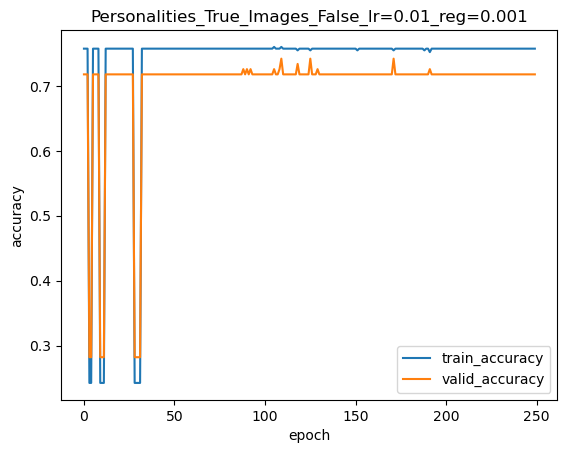

In [131]:
# ----------- Plotting data ---------------
epoch_nums = np.arange(n_epochs)
plt.plot(epoch_nums, train_loss, label="train_accuracy")
plt.plot(epoch_nums, valid_loss, label="valid_accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title(f"Personalities_{personalities}_Images_{images}_lr={lr}_reg={reg}")
plt.savefig(f'{total_name}.png')
plt.show()

In [71]:

plt.savefig(f"{total_name}.jpg")

                    

-------Accuracy------------
Train Accuracy = 0.8666666746139526
Valid Accuracy = 0.6774193644523621
Test Accuracy = 0.7200000286102295
